#ISPR - Midterm 3 - Assignment 2

##Acciaro Gennaro Daniele


## Assignment
DATASET (CIFAR-10): https://www.cs.toronto.edu/~kriz/cifar.html

Implement your own convolutional network, deciding how many layers, the type of layers and how they are interleaved, the type of pooling, the use of residual connections, etc. Discuss why you made each choice a provide performance results of your CNN on CIFAR-10.  

Now that your network is trained, you might try an adversarial attack to it. Try the simple Fast Gradient Sign method, generating one (or more) adversarial examples starting from one (or more) CIFAR-10 test images. It is up to you to decide if you want to implement the attack on your own or use one of the available libraries (e.g. foolbox,  CleverHans, ...). Display the original image, the adversarial noise and the final adversarial example.  


#Setup
These blocks take care of downloading the dataset, importing the necessary libraries and defining some utility functions.

In [ ]:
!pip install cleverhans
!pip install -q -U keras-tuner

In [ ]:
#Utilities:
def show_imgs(list_of_pics, list_of_titles=None):
    size = len(list_of_pics)
    plt.figure(figsize=(size*5, 16))

    for i, pic in enumerate(list_of_pics):
        plt.subplot(1, size, i+1)
        plt.imshow(scaleTo255(pic))
        if(list_of_titles is not None and list_of_titles[i] is not None):
            plt.title(list_of_titles[i])
        plt.axis("off")
   
    plt.show()

def scaleTo255(img):
    """This function scales a matrix of floats (from 0 to 1) into a integer (from 0 to 255)"""
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    return img

In [ ]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dropout,Flatten, Dense
from keras.layers import Input, concatenate 
from keras.models import Model

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

170508288/170498071 [==============================] - 11s 0us/step


# How did I solve the problem?

To solve this task, I split the problem into two phases. The first phase is to define the best architecture that can best classify the dataset. 
The second phase, instead, is to define an adversarial attack to reduce the accuracy of the model, although to the human eye, the dataset remains the same.

# Phase 1 - Finding the architecture

This phase is dedicated to the research of the best model to classify correctly the dataset. The model selection was done through the library Keras Tuner, but I added bias on the architecture to get better results. 

### Loss function

The best choice of loss for a multiclass classification problem is Cross Entropy.

In particular, I used the [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) because the dataset is not 1-hot encoded. This loss requires the softmax activaction function in the output layer.

In [ ]:
theLoss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### My architectural's biases

The hyperparameters of my architecture has been selected through a Model Selection phase (performed by Keras Tuner). Despite this, I had to implement some bias on it, to reduce the computation time of model selection.

Among the most important choices that I had to make, we find:

1. Three-level convolution architecture

  From the first empirical results, I noticed that a CNN with 3 levels of convolution gave me better results. Therefore, I implemented 3 levels of 2d-convolution and the parameters of these levels were selected by Keras Tuner.

2. Dropout

  Reading the paper ["Analysis on the Dropout Effect in Convolutional
Neural Networks"](http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf) with particular reference to Table 6, I thought that a good way to improve the accuracy of the model was to implement dropout levels. 

3. Batch Normalization

  Batch normalization is a tecnique useful to speed up tranining and to improve performance. For these reasons I have added between each layer of convolution and pooling, a layer of normalization.

4. The choice of pooling

  MaxPooling is useful when there are very bright pixels on dark backgrounds (e.g. the MNIST dataset). However, this is not our case, so I decided to use Average pooling.

5. Skipping Connection

  Referring to the ResNet archiecture, the technique of skipping connections could improve the performance of a CNN, because it reduces the effect of the vanish gradient.
  In this case I decided to compare the same archiecture both skipping connections and not doing it, then comparing the results.

### Model Selection with Keras Tuner (with skipping connection)

In [ ]:
training_epochs = 50
random_search_trial = 6
tuner_epochs = training_epochs
f_act = "relu"

I made two model selections (through two different Random Searches) using the native Keras framework to hyperparameters search : Keras Tuner.

The first Random Search uses an architecture with connection skips, while the second does not.

In [ ]:
def model_skip_connection_hypothesis(hp):
    input_layer = Input(shape=(32,32,3))

    #Layer 1:
    x =  Conv2D(
          filters=hp.Int('conv_1_filter', min_value=48, max_value=128, step=4),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5,8]),
          activation=f_act,
          input_shape=(32,32,3))(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Dropout(rate = hp.Choice('dropout_1_rate', values = [0.1,0.2,0.5]))(x)
    #Layer 2:
    x =  Conv2D(
          filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=4),
          kernel_size=hp.Choice('conv_2_kernel', values = [2,3]),
          activation=f_act)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Dropout(rate = hp.Choice('dropout_2_rate', values = [0.1,0.2,0.5]))(x)
    
    # Layer 3
    x =  Conv2D(
          filters=hp.Int('conv_3_filter', min_value=8, max_value=128, step=4),
          kernel_size=hp.Choice('conv_3_kernel', values = [2,3]),
          activation=f_act)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Dropout(rate = hp.Choice('dropout_3_rate', values = [0.1,0.2,0.5]))(x)


    x = Flatten()(x)
    x = Dense(
          units=hp.Int('dense_1_units', min_value=16, max_value=128, step=4),
          activation='relu'
      )(x)

    output_layer = Dense(10, activation="softmax")(x)

    model = Model(inputs = input_layer, outputs = output_layer)
    model.compile(optimizer="adam",
                loss=theLoss,
                metrics=['accuracy'])
    return model

In [ ]:
!!rm -rf keras_tuner_folder_skip

tuner = kt.RandomSearch(model_skip_connection_hypothesis,
                    objective='val_accuracy',
                    max_trials = random_search_trial,
                    directory='keras_tuner_folder_skip',
                    project_name='midterm3')

tuner.search(X_train, y_train, epochs=training_epochs, validation_split=0.2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 6 Complete [00h 03m 23s]
val_accuracy: 0.7581250071525574

Best val_accuracy So Far: 0.7581250071525574
Total elapsed time: 00h 24m 30s


Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.4926 - accuracy: 0.8357 - val_loss: 1.0525 - val_accuracy: 0.7163
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4678 - accuracy: 0.8395 - val_loss: 0.8528 - val_accuracy: 0.7576
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4540 - accuracy: 0.8404 - val_loss: 0.9037 - val_accuracy: 0.7466
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4497 - accuracy: 0.8436 - val_loss: 0.9908 - val_accuracy: 0.7274
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4383 - accuracy: 0.8477 - val_loss: 0.7890 - val_accuracy: 0.7570
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4297 - accuracy: 0.8492 - val_loss: 0.8358 - val_accuracy: 0.7606
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4291 - accuracy: 0.8494 - val_loss: 0.8707 - val_accuracy:

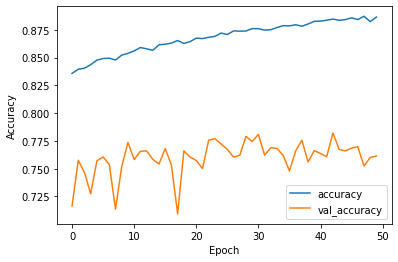

In [ ]:
best_model_with_skip = tuner.get_best_models()[0]

history = best_model_with_skip.fit(X_train, y_train, epochs=training_epochs, validation_data=(X_val,y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

_, acc_with_skip = best_model_with_skip.evaluate(X_val,y_val, verbose=2)
print("The accuracy of my model is: ",acc_with_skip)

### Model Selection with Keras Tuner (without skipping connection)

In [ ]:
def model_hypothesis(hp):
    model = tf.keras.Sequential([
        # Layer 1:                        
        Conv2D(
            filters=hp.Int('conv_1_filter', min_value=48, max_value=128, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values = [3,5,8]),
            activation=f_act,
            input_shape=(32,32,3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Dropout(rate = hp.Choice('dropout_1_rate', values = [0.1,0.2,0.5])),

        # Layer 2:
        Conv2D(
            filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values = [1,3]),
            activation=f_act,
            input_shape=(32,32,3)),
        BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        Dropout(rate = hp.Choice('dropout_2_rate', values = [0.1,0.2,0.5])),

        # Layer 3:
        Conv2D(
            filters=hp.Int('conv_3_filter', min_value=8, max_value=128, step=16),
            kernel_size=hp.Choice('conv_3_kernel', values = [1,3]),
            activation=f_act,
            input_shape=(32,32,3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Dropout(rate = hp.Choice('dropout_3_rate', values = [0.1,0.2,0.5])),

        Flatten(),
        Dense(
            units=hp.Int('dense_1_units', min_value=16, max_value=128, step=16),
            activation='relu'
        ),

        # Output
        Dense(10, activation="softmax")
    ])

    model.compile(optimizer="adam", loss=theLoss, metrics=['accuracy'])
    return model

In [ ]:
!!rm -rf keras_tuner_folder_noskip

tuner = kt.RandomSearch(model_skip_connection_hypothesis,
                    objective='val_accuracy',
                    max_trials = random_search_trial,
                    directory='keras_tuner_folder_noskip',
                    project_name='midterm3')

tuner.search(X_train, y_train, epochs=training_epochs, validation_split=0.2)

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 6 Complete [00h 04m 24s]
val_accuracy: 0.765250027179718

Best val_accuracy So Far: 0.7733749747276306
Total elapsed time: 00h 24m 54s


Epoch 1/50
1250/1250 [==============================] - 7s 5ms/step - loss: 0.3799 - accuracy: 0.8802 - val_loss: 0.7865 - val_accuracy: 0.7703
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3331 - accuracy: 0.8884 - val_loss: 0.8002 - val_accuracy: 0.7660
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3267 - accuracy: 0.8905 - val_loss: 0.7928 - val_accuracy: 0.7686
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3082 - accuracy: 0.8948 - val_loss: 0.9045 - val_accuracy: 0.7478
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3005 - accuracy: 0.8964 - val_loss: 0.9318 - val_accuracy: 0.7322
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2950 - accuracy: 0.8968 - val_loss: 0.8196 - val_accuracy: 0.7669
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2863 - accuracy: 0.8991 - val_loss: 0.8341 - val_accuracy:

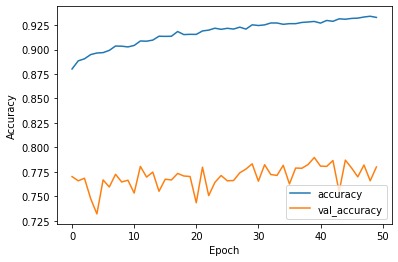

In [ ]:
best_model_without_skip = tuner.get_best_models()[0]

history = best_model_without_skip.fit(X_train, y_train, epochs=training_epochs, validation_data=(X_val,y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

_, acc_without_skip = best_model_without_skip.evaluate(X_val, y_val, verbose=2)
print("The accuracy of my model is: ",acc_without_skip)

## Final Model

In [ ]:
if acc_without_skip>acc_with_skip:
    model = best_model_without_skip
    accuracy = acc_without_skip
else:
    model = best_model_with_skip
    accuracy = acc_with_skip

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 116)       3248      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 116)       464       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 116)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 116)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 116)       53940     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 116)       464   

# Phase 2 - Adversarial attack (FGSM)

CNNs, in general, perform well on several tasks in the computer vision domain.

However, some attacks can confuse these architectures. Let's take a look at the Fast Gradient Sign Method.

This attack involves the creation of a specific kernel for each image; the output image resulting from the application of this kernel is an image very similar to the original image for a human eye, but completely different when classified by a CNN. 

To accomplish this an FGSM attack performs the gradient of the loss (which in our case is a Sparse Categorical Cross Entropy) with respect to the input image and then uses the sign of this gradient to generate a new image that maximizes the loss function.

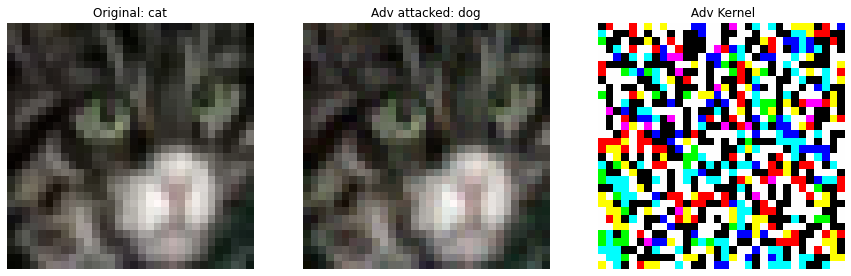

In [ ]:
index = 2816
original_image  = X_train[index]
original_label = labels[y_train[index][0]]

epsilon = 0.015

reshaped_original_image = tf.convert_to_tensor(original_image.reshape((1,32,32,3)))
adv_image = fast_gradient_method(model, reshaped_original_image, epsilon, np.inf, targeted=False)

output_distribution = model.predict(adv_image)
adv_output = np.argmax(output_distribution)
adv_output_label = labels[adv_output]

adv_image = np.reshape(adv_image, (32,32,3))
adv_kernel = adv_image-original_image

show_imgs([original_image, adv_image, adv_kernel], ["Original: "+str(original_label), "Adv attacked: "+ str(adv_output_label)," Adv Kernel"])

## Let’s confuse the model

We can now apply this technique to every image in the test set. We will then go on to see how the accuracy is reduced if we test our model on a dataset on which we have performed the attack (adv_X_test) compared to the original test set (X_test).

In [ ]:
adv_X_test = list()
adv_y_test = list()

for x,y in zip(X_test, y_test):
   adv_y_test.append(y)

   reshaped_original_image = tf.convert_to_tensor(x.reshape((1,32,32,3)))
   adv_image = fast_gradient_method(model, reshaped_original_image, epsilon, np.inf, targeted=False)
   adv_image = np.reshape(adv_image, (32,32,3))
   adv_X_test.append(adv_image)

Epoch 1/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.1872 - accuracy: 0.9332 - val_loss: 0.9093 - val_accuracy: 0.7839
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1817 - accuracy: 0.9343 - val_loss: 1.0190 - val_accuracy: 0.7625
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1813 - accuracy: 0.9358 - val_loss: 0.9019 - val_accuracy: 0.7839
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1783 - accuracy: 0.9361 - val_loss: 0.8882 - val_accuracy: 0.7820
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1800 - accuracy: 0.9365 - val_loss: 1.1709 - val_accuracy: 0.7480
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.1825 - accuracy: 0.9355 - val_loss: 0.9199 - val_accuracy: 0.7826
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1734 - accuracy: 0.9378 - val_loss: 0.9908 - val_accuracy:

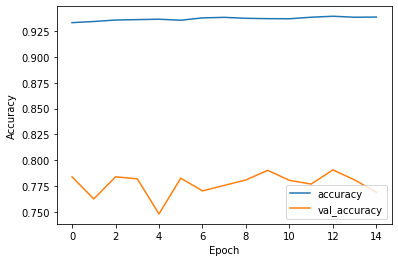

In [ ]:
model.compile(optimizer='adam', loss=theLoss, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
_, accuracy = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
_, test_acc = model.evaluate(np.array(adv_X_test), np.array(adv_y_test), verbose=0)
print("before we had an accuracy of ",accuracy, "; after performing the attack we get ",test_acc)

before we had an accuracy of  0.7712000012397766 ; after performing the attack we get  0.3091999888420105


# Finals observations

A weak aspect to highlight is the choice of the epsilon parameter. I chose it empirically, just to dimostrate how this attack works.

Another point to note, in my opinion, is how artificial and unlikely this attack is in production contexts, although it does demonstrate a possible leak in CNNs.

Personally, I also learned a lot from this midterm about model selection, having to carefully choose the correct parameters for Random Search.